# Fuzzy inference system
The goal of this notebook is to provide an implementation allowing you to explore the creation of a fuzzy inference system. We will demonstrate the use of this implementation in the tourist prediction problem, and we will ask you to test it in other problems.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

The implementation of the linguistic variable and the fuzzy rule are not written here. Instead they are loaded from python files.

In [2]:
import linguistic_variable as lv
import fuzzy_rule as fr

The constructor of the implementation of fuzzy inference system we propose receives 3 arguments as inputs:
- rules: a list of rules of type FuzzyRules (in file fuzzy_rule.py)
- aggregator: the function to use as aggregator. Options are:
    - OR_max: maximum
    - OR_probsum: probabilistic sum
    - OR_boundsum: bounded sum
- defuzzifier: the method used for defuzzifying the output. Options are:
    - COA: center of areas
    - MOM: minimum of maximums

In [3]:
class FIS:
    """
    This class implements a Fuzzy Inference System (FIS).
    Available aggregators are:
    - OR_max: maximum
    - OR_probsum: probabilistic sum
    - OR_boundsum: bounded sum
    Available defuzzifiers are:
    - COA: center of areas
    - MOM: minimum of maximums
    """
    
    def __mom(v, m):
        i = np.argmax(m)
        y_inf = v[min(i)]
        y_sup = v[max(i)]
        return (y_inf + y_sup) / 2.0
        
    __fuzzy_aggregators = {'OR_max': np.maximum,
                           'OR_probsum': lambda x,y: np.add(x, y) - np.multiply(x, y),
                           'OR_boundsum': lambda x,y: np.minimum(1, np.add(x, y))}
    __fuzzy_defuzzifiers = {'COA': lambda v,m: np.sum(np.multiply(v,m)) / np.sum(m),
                            'MOM': __mom}
    
    def __init__(self, rules, aggregator='OR_max', defuzzifier='COA'):
        """
        Three parameters are needed:
        rules: a list of objects of type FuzzyRule containing the rules of the system
        aggregator: the fuzzy operator to be used to aggregate the rules outputs
        defuzzifier: the defuzzifier function to use
        """
        self.rules = rules
        self.input_variables = set()
        for r in self.rules:
            for a in r.antecedent:
                self.input_variables.add(a[0])
            self.output_variable = r.consequent[0]
        
        assert aggregator in self.__fuzzy_aggregators.keys()
        self.aggregator = self.__fuzzy_aggregators[aggregator]
        
        assert defuzzifier in self.__fuzzy_defuzzifiers.keys()
        self.defuzzifier = defuzzifier
        
        self.input_values = dict()
        self.fuzzified_output = np.zeros(len(self.output_variable.input_values))
        self.defuzzified_output = 0.0
    
    def __str__(self):
        to_return = 'Input variables:\n'
        to_return += '\t' + str([i_v.name for i_v in self.input_variables]) + '\n'
        to_return += 'Output variables:\n'
        to_return += '\t' + self.output_variable.name + '\n'
        to_return += 'Rules:\n'
        for r in self.rules:
            to_return += '\t' + str(r) + '\n'
        return to_return
    
    def compute_antecedent_activations(self, input_values):
        """
        This function computes the activation of the antecedent of all rules.
        """
        self.input_values = input_values
        for r in self.rules:
            r.compute_antecedent_activation(input_values)
    
    def compute_consequent_activations(self):
        """
        This function computes the activation of the consequent of all rules.
        """
        for r in self.rules:
            r.compute_consequent_activation()
    
    def aggregate(self):
        """
        This function performs the aggregation of the rules outputs
        """
        self.fuzzified_output = np.zeros(len(self.output_variable.input_values))
        for r in self.rules:
            self.fuzzified_output = self.aggregator(self.fuzzified_output, r.consequent_activation)
    
    def defuzzify(self):
        """
        This function defuzzifies the fuzzified_output of the system
        """
        self.defuzzified_output = self.__fuzzy_defuzzifiers[self.defuzzifier](self.output_variable.input_values, self.fuzzified_output)
        return self.defuzzified_output
    
    def plot_variables(self):
        i = 1
        n_lv = len(self.input_variables) + 1
        for i_v in self.input_variables:
            pl.subplot(1, n_lv, i)
            i += 1
            i_v.plot()
        pl.subplot(1, n_lv, i)
        self.output_variable.plot()
    
    def plot_rules(self):
        n_r = len(self.rules)
        for i, r in enumerate(self.rules):
            pl.subplot(1, n_r, i+1)
            r.plot()
    
    def plot_output(self):
        pl.plot(self.output_variable.input_values, self.fuzzified_output)
        pl.axvline(self.defuzzified_output, color='black', linestyle='--')
        pl.ylim(0, 1.05)
        pl.grid()
        pl.title(self.output_variable.name + str(self.input_values))
    
    def plot2D(self, ax=None):
        """
        Only works for systems with two inputs!!
        """
        
        assert len(self.input_variables) == 2
        
        vars_list = []
        for v in self.input_variables:
            vars_list.append(v)
            
        var1 = vars_list[0]
        var2 = vars_list[1]
        n_var1 = len(var1.input_values)
        n_var2 = len(var2.input_values)
        
        input_values = {var1.name:0, var2.name:0}
        X, Y = np.meshgrid(var1.input_values, var2.input_values)
        Z = np.zeros((n_var2, n_var1))
        
        for i in np.arange(n_var1):
            for j in np.arange(n_var2):
                input_values[var1.name] = X[j,i]
                input_values[var2.name] = Y[j,i]
                self.compute_antecedent_activations(input_values)
                self.compute_consequent_activations()
                self.aggregate()
                Z[j,i] = self.defuzzify()

        if ax is None:
            ax = pl.gca(projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_xlabel(var1.name)
        ax.set_ylabel(var2.name)
        ax.set_zlabel(self.output_variable.name)
        
    def plot(self, size=None):
        if size is None:
            size = (12,4)
        pl.figure(figsize=size)
        self.plot_variables()
        pl.figure(figsize=size)
        self.plot_rules()
        pl.figure(figsize=size)
        self.plot_output()

## An example: "the tourists prediction problem"

We start by creating the linguistic variables involved in the problem

In [4]:
temperature = lv.LinguisticVariable('temperature', 0, 35, [17, 20, 26, 29], ['cold', 'warm', 'hot'], res=1.0)
sunshine = lv.LinguisticVariable('sunshine', 0, 100, [30, 50, 50, 100], ['cloudy', 'partsunny', 'sunny'], res=1.0)
tourists = lv.LinguisticVariable('tourists', 0, 100, [0, 50, 50, 100], ['low', 'medium', 'high'], res=1.0)

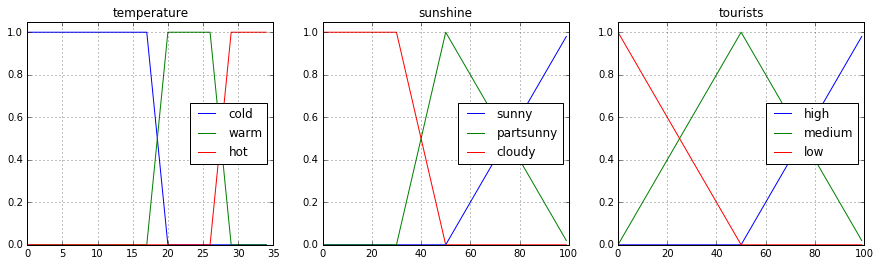

In [5]:
pl.figure(figsize=(15,4))
pl.subplot(1,3,1)
temperature.plot()
pl.subplot(1,3,2)
sunshine.plot()
pl.subplot(1,3,3)
tourists.plot()

Then, we create the three rules describing the system

In [6]:
rule_1 = fr.FuzzyRule('OR_max', [(temperature, 'hot'), (sunshine, 'sunny')], (tourists, 'high'), 'MIN')
rule_2 = fr.FuzzyRule('AND_min', [(temperature, 'warm'), (sunshine, 'partsunny')], (tourists, 'medium'), 'MIN')
rule_3 = fr.FuzzyRule('OR_max', [(temperature, 'cold'), (sunshine, 'cloudy')], (tourists, 'low'), 'MIN')

In [7]:
print rule_1
print rule_2
print rule_3

Fuzzy rule:
	IF temperature IS hot OR sunshine IS sunny
	THEN tourists is high
	Antecedent activation: 0.0
Fuzzy rule:
	IF temperature IS warm AND sunshine IS partsunny
	THEN tourists is medium
	Antecedent activation: 0.0
Fuzzy rule:
	IF temperature IS cold OR sunshine IS cloudy
	THEN tourists is low
	Antecedent activation: 0.0


Finally, we create the Fuzzy Inference System

In [8]:
tourist_prediction_example = FIS([rule_1, rule_2, rule_3])

In [9]:
print tourist_prediction_example

Input variables:
	['temperature', 'sunshine']
Output variables:
	tourists
Rules:
	Fuzzy rule:
	IF temperature IS hot OR sunshine IS sunny
	THEN tourists is high
	Antecedent activation: 0.0
	Fuzzy rule:
	IF temperature IS warm AND sunshine IS partsunny
	THEN tourists is medium
	Antecedent activation: 0.0
	Fuzzy rule:
	IF temperature IS cold OR sunshine IS cloudy
	THEN tourists is low
	Antecedent activation: 0.0



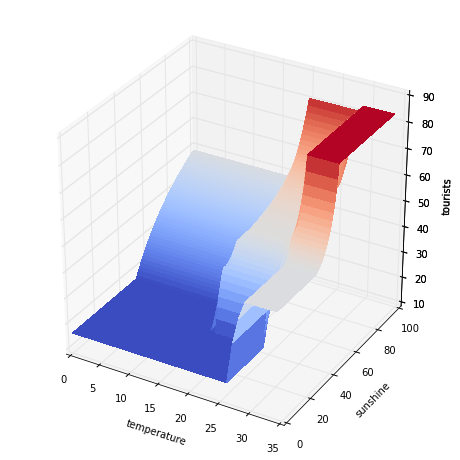

In [10]:
pl.figure(figsize=(8,8))
tourist_prediction_example.plot2D()

And we define some input values for testing

In [ ]:
input_values = {'temperature': 19, 'sunshine': 60}

### Antecedent activation

In [ ]:
tourist_prediction_example.compute_antecedent_activations(input_values)

In [ ]:
print tourist_prediction_example

In [ ]:
pl.figure(figsize=(12,4))
tourist_prediction_example.plot_variables()

### Consequent activation

In [ ]:
tourist_prediction_example.compute_consequent_activations()

In [ ]:
pl.figure(figsize=(12,4))
tourist_prediction_example.plot_rules()

### Aggregation and Defuzzification

In [ ]:
tourist_prediction_example.aggregate()
tourist_prediction_example.defuzzify()

In [ ]:
tourist_prediction_example.plot_output()

### Plot

In [ ]:
tourist_prediction_example.plot()

## Exercise
1. Reproduce the fuzzy systems studied in class, simulate their behaviour, compare your results with those discussed in class, and comment:
    - Car acceleration problem. How would you create the system given that the current implementation does not have a default rule (it does not support the "else" condition)?
    - Inverted pendulum problem. What could you say about the use of the default rule in this case?
    - Temperature control  

2. The current implementation of FIS does not have a default rule. Modify the provided implementation and add a default rule to the fuzzy inference system. Show its behaviour using the "car acceleration problem"

3. The current implementation of FIS is of type Mamdani. Modify the sources and create a FIS of type singleton. Show its behaviour using the "temperature control problem". You should:
    - create a new linguistic variable that does not interpolate between known values
    - create a new rule which employs the new type of linguistic value in its consequent